In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
from matplotlib.colors import ListedColormap
import string
import re
%matplotlib inline
pth = r"C:\EPFL\2018-2019\nltk_data" #change location according to your nltk data path
nltk.data.path.append(pth)
sns.set()

# Load data and merge into single dataframe

In [2]:
data_folder = 'twitter-datasets'
train_pos = pd.read_table(data_folder + '/train_pos.txt', header =None, names=['text'], sep='\n')
train_pos['sentiment'] = 'positive'
train_neg = pd.read_table(data_folder + '/train_neg.txt', header =None, names=['text'], sep='\n')
train_neg['sentiment'] = 'negative'

data = pd.concat([train_neg, train_pos]) #merge positive and negative tweets
data = data.sample(frac=1).reset_index(drop=True) #shuffle the datas
data.head()

,text,sentiment
0,<user> i know ain't it's great,positive
1,i love our fans ! there all so beautiful ! x <...,positive
2,i love our fans ! there all so beautiful ! x <...,positive
3,<user> sorry about lunch today,negative
4,compatible brother lc65m high yield premium in...,negative


# Clean data

In [3]:
#deal with punct later, try without first to not remove emoticons such as ;) or :p

#Now we just get rid of numbers, # and url and user
pat = [r'<user>', r'<url>', r'#', r'[0-9]']

#manual lemmatization on negative english auxiliaries form
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text) : 
    allpat = text
    for p1 in pat :
        allpat = re.sub(p1,'',allpat)    
    
    allpat =  allpat.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], allpat)
    words = neg_handled.split()
    return (" ".join(words)).strip()

**test our cleaning function**

In [4]:
p = "not happy at all !!!!! #Ilove washington DC 567 xDDD ahaha don't you say ! :p  ;) ('_') ///     why you do this."

In [5]:
tweet_cleaner(p)

"not happy at all !!!!! ilove washington dc xddd ahaha do not you say ! :p ;) ('_') /// why you do this."

Its working for now, lets give it a try like that

In [6]:
data = pd.DataFrame(data.apply(lambda row : pd.Series([tweet_cleaner(row[0]), row[1]]), axis=1)) #clean each tweet
data.columns = ['text', 'sentiment']

In [7]:
data.head()

,text,sentiment
0,i know ain't it's great,positive
1,i love our fans ! there all so beautiful ! x,positive
2,i love our fans ! there all so beautiful ! x,positive
3,sorry about lunch today,negative
4,compatible brother lcm high yield premium ink ...,negative


In [8]:
#Used to save data cleaned
#data.to_pickle('clean_tweets') 

# Feature extraction and testing

In [11]:
import sklearn
#from sklearn.model_selection.cross_validation import train_test_split
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [29]:
from progressbar import ProgressBar

In [30]:

def countvect(n_features_r, d, cv) :
    n_features_range = n_features_r
    features = []
    accuracies = []
    pbar = ProgressBar()
    for i in pbar(n_features_range) :
        vect = CountVectorizer(ngram_range=(1,3), binary =True, max_features=i)
        X = vect.fit_transform(d['text'].values)
        y = d['sentiment']
        logreg = LogisticRegression()
        accuracy = model_selection.cross_val_score(logreg, X, y, cv=cv, scoring="accuracy")
        features.append(i)
        accuracies.append(np.mean(accuracy))
    return features, accuracies

def tfidf(n_features_r, d, cv) :
    n_features_range = n_features_r
    features = []
    accuracies = []
    pbar = ProgressBar()
    for i in pbar(n_features_range) :
        vect = TfidfVectorizer(ngram_range=(1,3), binary =True, max_features=i)
        X = vect.fit_transform(d['text'].values)
        y = d['sentiment']
        logreg = LogisticRegression()
        accuracy = model_selection.cross_val_score(logreg, X, y, cv=cv, scoring="accuracy")
        features.append(i)
        accuracies.append(np.mean(accuracy))
    return features, accuracies

In [31]:
n_features =range(10000, 500000, 50000)
cv = 5

## Count Vectorizer

In [32]:
features, accuracies = countvect(n_features, data, cv)

100% |########################################################################|


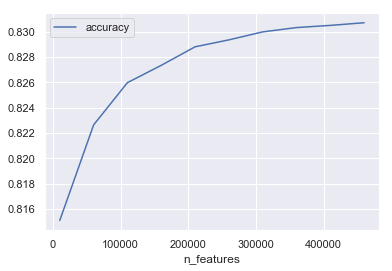

In [47]:
cv_acc = (pd.DataFrame([features, accuracies]).T)
cv_acc.columns = ['n_features', 'accuracy']
cv_acc.plot(x="n_features", y="accuracy")

 ## TF-IDF Vectorizer

In [50]:
features_idf, accuracyidf = tfidf(n_features, data, cv)

100% |########################################################################|


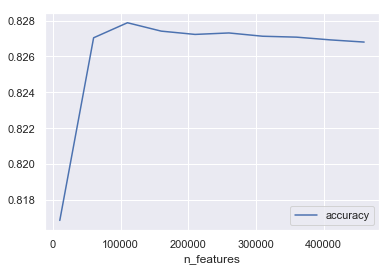

In [52]:
tf_acc = (pd.DataFrame([features_idf, accuracyidf]).T)
tf_acc.columns = ['n_features', 'accuracy']
tf_acc.plot(x="n_features", y="accuracy")